## Fraud Detection Classification Problem using Quantative and Qualitative Features

In [108]:
# Set Directory
import os
os.getcwd()

'C:\\Users\\Sumanth William Laza\\OneDrive\\A_DataScienceProgram\\A_INSOFE\\A_MiTH'

In [109]:
import numpy as np
import pandas as pd

# 1. Preprocessing Libraries
from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder    #Dummification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    #NEW!
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold    #Hyperparameter tuning, StratifiedKFold
# another way to cross-validate
from sklearn.compose import ColumnTransformer


# 2. Algorithm Import
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.ensemble import AdaBoostClassifier


# 3. Evaluation Library
from sklearn.metrics import confusion_matrix

# 4. Viz Lib
import matplotlib.pyplot as plt 
import seaborn as sns

# 5. Misc Lib
# !pip install imblearn
from imblearn.over_sampling import SMOTE    #Data/Class imbalance

import warnings
warnings.filterwarnings('ignore')

In [110]:
#Train Data Reading
m_train_data = pd.read_csv(filepath_or_buffer = 'train_merchant_data-1561627820784.csv', sep = ",", header = 0)
o_train_data = pd.read_csv(filepath_or_buffer = 'train_order_data-1561627847149.csv', sep = ",", header = 0)
y_train_data = pd.read_csv(filepath_or_buffer = 'train-1561627878332.csv', sep = ",", header = 0)
print(m_train_data.shape)
print(o_train_data.shape)
print(y_train_data.shape)


#Test Data Reading   
m_test_data = pd.read_csv(filepath_or_buffer = 'test_merchant_data-1561627903902.csv', sep = ",", header = 0)
o_test_data = pd.read_csv(filepath_or_buffer = 'test_order_data-1561627931868.csv', sep = ",", header = 0)
y_test_data = pd.read_csv(filepath_or_buffer = 'test-1561627952093.csv', sep = ",", header = 0)
print(m_test_data.shape)
print(o_test_data.shape)
print(y_test_data.shape)   # 'y' Test Data is unlabelled

(54213, 7)
(54213, 7)
(54213, 2)
(13554, 7)
(13554, 7)
(13554, 1)


**Understanding the Dataset**

In [111]:
print(m_train_data.columns, "\n")
print(o_train_data.columns, "\n")   #Join on 'Merchant_ID'

print(m_train_data.dtypes, "\n")   #Mixture of Integers and Objects
print(o_train_data.dtypes)

Index(['Ecommerce_Provider_ID', 'Merchant_ID', 'Merchant_Registration_Date',
       'Registered_Device_ID', 'Gender', 'Age', 'IP_Address'],
      dtype='object') 

Index(['Customer_ID', 'Order_ID', 'Date_of_Order', 'Order_Value_USD',
       'Order_Source', 'Order_Payment_Method', 'Merchant_ID'],
      dtype='object') 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
dtype: object 

Customer_ID              int64
Order_ID                object
Date_of_Order           object
Order_Value_USD          int64
Order_Source            object
Order_Payment_Method    object
Merchant_ID              int64
dtype: object


In [112]:
m_train_data.head()

Ecommerce_Provider_ID  Merchant_ID Merchant_Registration_Date  \
0                1746213        50448        2018-05-01 21:15:11   
1                1746213       338754        2018-04-14 10:13:00   
2                1746213       291127        2018-06-20 07:44:22   
3                1746213       319919        2018-06-27 01:41:39   
4                1746213       195911        2018-01-05 00:55:41   

  Registered_Device_ID Gender  Age      IP_Address  
0        VATQMMZTVOZUT      F   39   48.151.136.76  
1        LJCILLBRQZNKS      M   35    94.9.145.169  
2        JFVHSUGKDAYZV      F   40   58.94.157.121  
3        WFRXMPLQYXRMY      M   37  193.187.41.186  
4        GGHKWMSWHCMID      F   27   125.96.20.172

In [113]:
m_train_data.describe()  #No NA's in numerical data

Ecommerce_Provider_ID    Merchant_ID           Age
count                54213.0   54213.000000  54213.000000
mean               1746213.0  200395.176212     33.122240
std                      0.0  115398.486895      8.630091
min                1746213.0       2.000000     18.000000
25%                1746213.0  100997.000000     27.000000
50%                1746213.0  200574.000000     32.000000
75%                1746213.0  300407.000000     39.000000
max                1746213.0  399993.000000     72.000000

In [114]:
m_train_data.describe(include = 'object')

Merchant_Registration_Date Registered_Device_ID Gender     IP_Address
count                       54213                54213  54213          54213
unique                      54213                51291      2          52028
top           2018-07-04 03:46:07        QGWUOPUHKKOWQ      M  107.136.93.76
freq                            1                    9  31761              9

In [115]:
o_train_data.describe()   #No NA's in o_train_data (Quant)

Customer_ID  Order_Value_USD    Merchant_ID
count   54213.000000     54213.000000   54213.000000
mean   137966.285208        92.230240  200395.176212
std     15563.516156        45.673263  115398.486895
min    111234.000000        22.000000       2.000000
25%    124471.000000        55.000000  100997.000000
50%    137864.000000        88.000000  200574.000000
75%    151405.000000       122.000000  300407.000000
max    165000.000000       385.000000  399993.000000

In [116]:
o_train_data.describe(include = 'object')

Order_ID        Date_of_Order Order_Source Order_Payment_Method
count          54213                54213        54213                54213
unique         54213                54161            3                    5
top     a80df83a0626  2018-05-11 00:44:01          SEO          Credit Card
freq               1                    2        21884                21844

**Merging Dataframes on Merchant_ID**

In [117]:
train_data = pd.merge(left = m_train_data, right = o_train_data, how = 'outer', on = 'Merchant_ID')
train_data = pd.merge(left = train_data, right = y_train_data, how = 'outer', on = 'Merchant_ID')

test_data = pd.merge(left = m_test_data, right = o_test_data, how = 'outer', on = 'Merchant_ID')
test_data = pd.merge(left = test_data, right = y_test_data, how = 'outer', on = 'Merchant_ID')

In [118]:
print(train_data.shape, '\n')
print(train_data.dtypes)

(54213, 14) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
Fraudster                      int64
dtype: object


In [119]:
print(test_data.shape, '\n')
print(test_data.dtypes)

(13554, 13) 

Ecommerce_Provider_ID          int64
Merchant_ID                    int64
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                    int64
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
dtype: object


In [120]:
train_data.describe()

Ecommerce_Provider_ID    Merchant_ID           Age    Customer_ID  \
count                54213.0   54213.000000  54213.000000   54213.000000   
mean               1746213.0  200395.176212     33.122240  137966.285208   
std                      0.0  115398.486895      8.630091   15563.516156   
min                1746213.0       2.000000     18.000000  111234.000000   
25%                1746213.0  100997.000000     27.000000  124471.000000   
50%                1746213.0  200574.000000     32.000000  137864.000000   
75%                1746213.0  300407.000000     39.000000  151405.000000   
max                1746213.0  399993.000000     72.000000  165000.000000   

       Order_Value_USD    Fraudster  
count     54213.000000  54213.00000  
mean         92.230240      0.09269  
std          45.673263      0.29000  
min          22.000000      0.00000  
25%          55.000000      0.00000  
50%          88.000000      0.00000  
75%         122.000000      0.00000  
max         385.000000      1.00000

### Pre-Processing Data and Exploratory Data Analysis

Pre-processing steps of the Train Data will be Applied to Test Data respectively. 

**Notes on Quantative Features**

'Merchant_ID', 'Customer_ID' will be converted to dtype 'object'.

'Ecommerce_Provider_ID' will be dropped due to No Information Gain.

In [121]:
train_data.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)
test_data.drop(labels = 'Ecommerce_Provider_ID', axis = 1, inplace = True)

In [122]:
train_data.shape

(54213, 13)

In [127]:
train_data

Merchant_ID Merchant_Registration_Date Registered_Device_ID Gender  \
0            50448        2018-05-01 21:15:11        VATQMMZTVOZUT      F   
1           338754        2018-04-14 10:13:00        LJCILLBRQZNKS      M   
2           291127        2018-06-20 07:44:22        JFVHSUGKDAYZV      F   
3           319919        2018-06-27 01:41:39        WFRXMPLQYXRMY      M   
4           195911        2018-01-05 00:55:41        GGHKWMSWHCMID      F   
5            51878        2018-07-29 05:40:41        YSUUQMHOIJZHJ      M   
6           205612        2018-02-03 05:37:07        VOQNWQHJUKFSZ      F   
7           300823        2018-02-24 12:16:03        BQKBQIXSRMCHT      M   
8           172822        2018-01-22 12:29:32        MKGAJACYBWCXO      F   
9           241476        2018-01-11 22:05:15        JJHGNMWRZRCML      M   
10          282981        2018-02-25 16:14:39        ENWOHXNLVKHUM      M   
11          209856        2018-04-07 09:13:18        ZRGIOMOSCSWRY      F   
12          112383        2018-05-09 21:53:08        FANJQIHNZCBLK      F   
13          224741        2018-07-17 23:11:40        ZBMJYRLDFWDZH      M   
14           53780        2018-02-01 13:57:08        IIVGTDWBOOCWF      F   
15          313525        2018-07-29 14:11:39        QWKTKIPMQRAXM      F   
16          190744        2018-06-18 00:17:06        GDPQAXLCESTGH      M   
17           27166        2018-03-05 05:36:00        RKPZXEZTNVREZ      M   
18           19528        2018-03-01 19:21:50        BXVJODDAGSUCB      M   
19          289039        2018-06-24 22:14:27        ERCSCRGEPEMAZ      F   
20          279462        2018-07-16 03:20:07        PRSFPXRRYRXQX      M   
21          341655        2018-08-12 20:35:22        ANPBMJCRPNTAC      F   
22          163262        2018-06-28 23:30:00        BHLVUPKGDEOZO      M   
23          252403        2018-06-26 12:25:16        RLNKPJZWXTAAK      F   
24          298934        2018-01-19 04:37:19        EYKIQWHOTRBHX      M   
25          262707        2018-01-12 18:18:08        EJIPHRMSYBRQA      F   
26          241015        2018-01-25 13:15:06        PDIBAVIROPLSD      F   
27          364918        2018-04-12 19:44:49        MUSENEHGWDGEB      F   
28          235887        2018-02-04 21:50:44        SPDMKWBYXVENN      F   
29          180180        2018-07-13 08:23:03        DKKPRTIHNIQGV      M   
...            ...                        ...                  ...    ...   
54183       365046        2018-02-18 04:36:43        USHBKAHEHQNYC      F   
54184       247679        2018-03-14 06:27:23        KVITNDBZNBCBR      F   
54185       356755        2018-05-30 12:14:07        PPSJAIJKREWHG      M   
54186       189989        2018-08-11 15:01:12        NJCLAZCWJTNXH      M   
54187        42845        2018-07-20 07:45:13        EKJPWHFOSMWEA      M   
54188       121182        2018-08-13 15:43:21        TGYVEQALKAHJF      F   
54189       340922        2018-01-06 20:27:15        APHJIEZLINQLB      F   
54190       224375        2018-04-15 06:06:51        YDIJBSIEBXUMT      F   
54191        92605        2018-05-25 01:52:21        EUETXCMELSZUG      F   
54192       328210        2018-07-26 06:14:21        VPCOPKMHMXWOI      M   
54193       210473        2018-06-27 20:28:29        UVXBUNGCOKGQQ      F   
54194       292414        2018-03-30 20:38:23        BOFSQTHAHOCQM      M   
54195       230433        2018-02-14 18:11:31        SBNGFLGDTPMAN      F   
54196       198679        2018-01-07 08:34:31        OKJCSTKWSXZHJ      M   
54197       109696        2018-05-27 13:01:58        KTUUNYXJYETCN      F   
54198       269730        2018-02-05 04:08:23        UZDHVTNXUOMMV      M   
54199       182162        2018-07-24 23:57:12        QADGTLORGGNAV      M   
54200       267359        2018-01-04 03:02:37        ZOEHFCSFEUQEA      M   
54201       324846        2018-03-21 11:53:07        YCMNPYLFZDNWI      F   
54202        37129        2018-06-16 20:31:01        TQUQESKIABGIE      M   
542

In [128]:
#Split X_train, y_train, X_test, y_test
X_train = train_data.iloc[:, 0:12 ]
X_test = test_data.iloc[:, 0:12] 
y_train= train_data['Fraudster']
y_train = y_train.to_frame()

In [132]:
X_train[['Merchant_ID', 'Customer_ID']] = X_train[['Merchant_ID', 'Customer_ID']].astype('object')
X_test[['Merchant_ID', 'Customer_ID']] = X_test[['Merchant_ID', 'Customer_ID']].astype('object')

In [133]:
X_train.dtypes

Merchant_ID                   object
Merchant_Registration_Date    object
Registered_Device_ID          object
Gender                        object
Age                            int64
IP_Address                    object
Customer_ID                   object
Order_ID                      object
Date_of_Order                 object
Order_Value_USD                int64
Order_Source                  object
Order_Payment_Method          object
dtype: object

In [19]:
train_data.describe(include = 'object')

Merchant_ID Merchant_Registration_Date Registered_Device_ID Gender  \
count         54213                      54213                54213  54213   
unique        54213                      54213                51291      2   
top          367309        2018-07-04 03:46:07        QGWUOPUHKKOWQ      M   
freq              1                          1                    9  31761   

           IP_Address  Customer_ID      Order_ID        Date_of_Order  \
count           54213        54213         54213                54213   
unique          52028        34081         54213                54161   
top     107.136.93.76       111658  a80df83a0626  2018-02-17 02:50:22   
freq                9            7             1                    2   

       Order_Source Order_Payment_Method  
count         54213                54213  
unique            3                    5  
top             SEO          Credit Card  
freq          21884                21844

Percentage Distribution of Order Sources

In [194]:
train_data['Order_Source'].value_counts(normalize = True)

SEO       0.403667
Ads       0.392138
Direct    0.204195
Name: Order_Source, dtype: float64

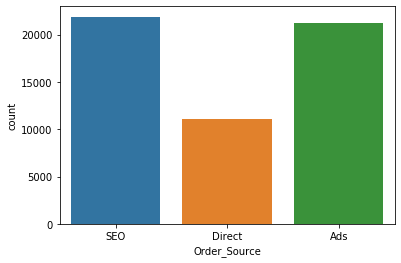

SEO       21884
Ads       21259
Direct    11070
Name: Order_Source, dtype: int64

In [193]:
sns.countplot(x='Order_Source', data=train_data)
plt.show()
train_data.Order_Source.value_counts()

In [199]:
X_train.describe()

Age  Order_Value_USD
count  54213.000000     54213.000000
mean      33.122240        92.230240
std        8.630091        45.673263
min       18.000000        22.000000
25%       27.000000        55.000000
50%       32.000000        88.000000
75%       39.000000       122.000000
max       72.000000       385.000000

Distribution of 'Age' is fairly symmetrical. Mean = 33.12, Median = 32

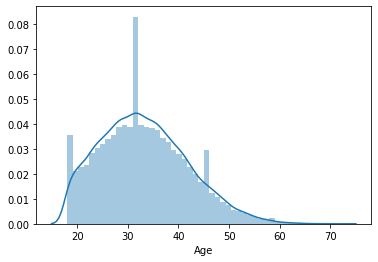

In [198]:
# Check distribution of age
# Density Curve + Histogram, shows distribution of Continuous Feature
%matplotlib inline
sns.distplot(train_data["Age"]) #NT: y is percentage count 

In [196]:
train_data['Order_Payment_Method'].value_counts(normalize = True)

Credit Card         0.402929
Internet Banking    0.243355
Debit Card          0.167303
E-wallet            0.161197
Cash On Delivery    0.025215
Name: Order_Payment_Method, dtype: float64

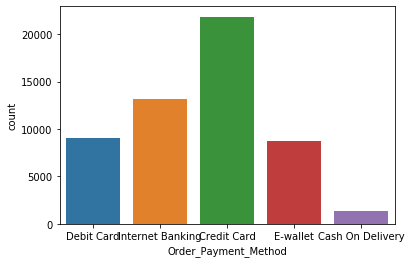

Credit Card         21844
Internet Banking    13193
Debit Card           9070
E-wallet             8739
Cash On Delivery     1367
Name: Order_Payment_Method, dtype: int64

In [195]:
sns.countplot(x='Order_Payment_Method', data=train_data)
plt.show()
train_data.Order_Payment_Method.value_counts()

**Notes on Qualitative Features**

'Order_Source': Has 3 Levels - SEO, Ads, Direct

'Order_Payment_Method': Has 5 Levels - Credit Card, Internet Banking, Debit Card, E-wallet, Cash On Delivery

'IP_Address': Should be converted to Human readable format (Decimal)

'Order_Source', 'Order_Payment_Method', 'Gender': Can be converted to 'category' dtype

In [134]:
X_train[['Order_Source', 'Order_Payment_Method', 'Gender']] = X_train[['Order_Source', 'Order_Payment_Method', 'Gender']].astype('category')
X_test[['Order_Source', 'Order_Payment_Method', 'Gender']] = X_test[['Order_Source', 'Order_Payment_Method', 'Gender']].astype('category')

In [135]:
X_train.dtypes

Merchant_ID                     object
Merchant_Registration_Date      object
Registered_Device_ID            object
Gender                        category
Age                              int64
IP_Address                      object
Customer_ID                     object
Order_ID                        object
Date_of_Order                   object
Order_Value_USD                  int64
Order_Source                  category
Order_Payment_Method          category
dtype: object

In [137]:
X_train['IP_Address'].head()

0     48.151.136.76
1      94.9.145.169
2     58.94.157.121
3    193.187.41.186
4     125.96.20.172
Name: IP_Address, dtype: object

**IP Address Country  step was abandoned due to Long processing time**

In [100]:
train_data.head()

Merchant_ID Merchant_Registration_Date Registered_Device_ID Gender  Age  \
0       50448        2018-05-01 21:15:11        VATQMMZTVOZUT      F   39   
1      338754        2018-04-14 10:13:00        LJCILLBRQZNKS      M   35   
2      291127        2018-06-20 07:44:22        JFVHSUGKDAYZV      F   40   
3      319919        2018-06-27 01:41:39        WFRXMPLQYXRMY      M   37   
4      195911        2018-01-05 00:55:41        GGHKWMSWHCMID      F   27   

   IP_Address Customer_ID      Order_ID        Date_of_Order  Order_Value_USD  \
0   815237196      129697  3b8983a83c7b  2018-07-30 10:59:13               90   
1  1577685417      117390  34b5eb921228  2018-06-15 11:19:47               98   
2   979279225      120162  41a1c86ff08b  2018-08-13 10:06:26               95   
3  3250268602      128228  e8c3ad80d916  2018-07-22 15:46:51              100   
4  2103448748      136029  e71ab1f26785  2018-04-16 08:02:44               78   

  Order_Source Order_Payment_Method  
0          SEO           Debit Card  
1          SEO     Internet Banking  
2          SEO          Credit Card  
3       Direct             E-wallet  
4          SEO             E-wallet

### Feature Engineering

Using IP Bound info, Country of transaction origin can be found

**NOTE: Due to high processing and search time this step was abandoned even though being logically valid**

In [138]:
X_test.head()

Merchant_ID Merchant_Registration_Date Registered_Device_ID Gender  Age  \
0       53637        2018-02-11 20:50:29        PTMLBENYMQCTV      F   40   
1      243517        2018-04-06 13:19:39        HMCLDZUZPWZRR      M   39   
2      343640        2018-01-12 16:47:49        VLGSMAPXISSEJ      M   23   
3       69889        2018-02-19 21:58:52        ZINHISBBOKQXT      M   34   
4      125706        2018-05-17 15:50:19        WFKEAOTPHTYEO      M   20   

       IP_Address Customer_ID      Order_ID        Date_of_Order  \
0  134.162.124.62      157068  a032de091f51  2018-03-09 09:09:42   
1    152.76.98.87      112534  0d563f0606d6  2018-06-13 20:11:19   
2    31.202.3.255      148774  18fb0fa888b6  2018-04-14 04:19:36   
3  12.242.168.185      114528  ed1eb920d721  2018-04-01 13:55:44   
4    26.61.210.47      120940  313dcf962627  2018-05-25 02:08:18   

   Order_Value_USD Order_Source Order_Payment_Method  
0               60          SEO          Credit Card  
1               28          SEO          Credit Card  
2               75          Ads           Debit Card  
3               98          SEO          Credit Card  
4               35          SEO          Credit Card

**Model Building 1**: Logistic Regression

In [139]:
tn_1 = X_train.copy()
tt_1 = X_test.copy()

In [140]:
tn_1.dtypes

Merchant_ID                     object
Merchant_Registration_Date      object
Registered_Device_ID            object
Gender                        category
Age                              int64
IP_Address                      object
Customer_ID                     object
Order_ID                        object
Date_of_Order                   object
Order_Value_USD                  int64
Order_Source                  category
Order_Payment_Method          category
dtype: object

In [141]:
num_attr = list(tn_1.select_dtypes('int64').columns)
cat_attr = list(tt_1.select_dtypes('category').columns)

In [142]:
# Numerical Pipeline: Pipeline has 2 operation - SimpleImputer() + StandardScaler()
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])    

# Categorical Pipeline: Pipeline has 2 operation - SimpleImputer() + OneHotEncoder()
categorical_transformer = Pipeline(steps =[('onehot', OneHotEncoder(handle_unknown='ignore'))])
#SimpleImputer strategy ='constant', then fill_values = 'Constant value string written here'

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_attr),
        ('cat', categorical_transformer, cat_attr)])

In [143]:
clf_logreg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression())])

In [145]:
y_train.shape

(54213, 1)

In [146]:
clf_logreg.fit(tn_1, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['Age', 'Order_Value_USD']), ('ca...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [149]:
train_pred = clf_logreg.predict(tn_1)
test_pred = clf_logreg.predict(tt_1)test_

print(clf_logreg.score(tn_1, y_train))
print(confusion_matrix(y_true=y_train, y_pred = train_pred))

0.9073100547839079
[[49188     0]
 [ 5025     0]]


In [151]:
test_pred_logreg_df = pd.DataFrame({'Fraudster':test_pred})
logreg_df = pd.concat([X_test['Merchant_ID'], test_pred_logreg_df], axis = 1)
logreg_df.to_csv("LogReg_sample.csv", index = False)

In [ ]:
Accuracy_test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#Acc=
Precision_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,1]+confusion_matrix_test[0,1])
#Prec=
Recall_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#Recall=
print("Test Precision: ",Precision_Test)
print("Test Recall: ",Recall_Test)
print("Train Accuracy: ",Accuracy_test)

**Model 2: Decision Tree Model**

In [152]:
# import time
# start_time = time.time()
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier()), ])

dt_param_grid = {'classifier__criterion': ['entropy'], 'classifier__max_depth': [10], 
                 "classifier__min_samples_split": [4],"classifier__min_samples_leaf": [5]}
#using double underscore '__' to match hyperparamter value to the 'classifier' or Operation assigned in Pipeline() 

# Add to GridSearchCV
dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5, refit=True)

# Build Model
dt_grid.fit(X_train, y_train)
# end_time = time.time()
# print("-------%s seconds elapsed----------", (end_time - start_time))

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['Age', 'Order_Value_USD']), ('ca...      min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'classifier__criterion': ['entropy'], 'classifier__max_depth': [10], 'classifier__min_samples_split': [4], 'classifier__min_samples_leaf': [5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [153]:
dt_grid.best_params_

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 10,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 4}

In [156]:
train_pred = dt_grid.predict(X_train)
test_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(confusion_matrix(y_true=y_train, y_pred = train_pred))

confusion_matrix_test = confusion_matrix(y_true=y_train, y_pred =  train_pred)


0.9094128714514969
[[49082   106]
 [ 4805   220]]


In [158]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("Conf Matrix : \n", confusion_matrix(y_train, train_pred))
print("\nTEST DATA ACCURACY",accuracy_score(y_train, train_pred))
print("\nTEST DATA Precision", precision_score(y_train, train_pred))
print("\nTEST DATA Recall", recall_score(y_train, train_pred))
print("\nTest data f1-score for class '1'",f1_score(y_train, train_pred,pos_label=1))
print("\nTest data f1-score for class '0'",f1_score(y_train, train_pred,pos_label=0))

Conf Matrix : 
 [[49082   106]
 [ 4805   220]]

TEST DATA ACCURACY 0.9094128714514969

TEST DATA Precision 0.6748466257668712

TEST DATA Recall 0.04378109452736319

Test data f1-score for class '1' 0.08222762100541954

Test data f1-score for class '0' 0.9523550812515159


In [160]:
test_pred_dt_df = pd.DataFrame({'Fraudster':test_pred})
dt_df = pd.concat([X_test['Merchant_ID'], test_pred_dt_df], axis = 1)
dt_df.to_csv("dt_sample.csv", index = False)